In [1]:
import requests
from tqdm import tqdm
import time

# 카카오 API

- 키워드로 장소 검색: https://developers.kakao.com/docs/latest/ko/local/dev-guide#search-by-keyword
- 카카오 개발자 API 키 발급: https://developers.kakao.com/
  - App 생성
  - REST API 키 복사, 붙여넣기

In [2]:
app_key = 'KakaoAK ' + '2717863e0f967d83afc18fe429eac7e3'

url = 'https://dapi.kakao.com/v2/local/search/keyword.json'

params = {
    'query': '치킨',
    'category_group_code': 'FD6', # 음식점
    'page': 45
}

headers = {
    'Authorization': app_key
}

res = requests.get(url, params=params, headers=headers).json()

print(res.keys())

dict_keys(['documents', 'meta'])


In [3]:
res['documents']

[{'address_name': '서울 성북구 안암동5가 104-41',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '946837172',
  'phone': '02-922-0077',
  'place_name': '삼성통닭 본점',
  'place_url': 'http://place.map.kakao.com/946837172',
  'road_address_name': '서울 성북구 고려대로24길 60',
  'x': '127.029336463953',
  'y': '37.5834566502029'},
 {'address_name': '서울 마포구 서교동 402-4',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '26871883',
  'phone': '02-324-7175',
  'place_name': '철인7호치킨 홍대점',
  'place_url': 'http://place.map.kakao.com/26871883',
  'road_address_name': '서울 마포구 양화로6길 99-3',
  'x': '126.919799225218',
  'y': '37.5485032450096'},
 {'address_name': '서울 강남구 역삼동 817-8',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '888590919',
  'phone': '02-554-9294',
  'place_name': '꼬꼬아찌숯불치킨 강남역점',
  'plac

In [4]:
res['meta']

{'is_end': True,
 'pageable_count': 45,
 'same_name': {'keyword': '치킨', 'region': [], 'selected_region': ''},
 'total_count': 62669}

# 한계
- 45페이지까지의 값밖에 받아올 수 없음

In [5]:
params = {
    'query': '치킨',
    'page': 46
}

res = requests.get(url, params=params, headers=headers).json()

print(res)

{'errorType': 'InvalidArgument', 'message': 'page is more than max'}


# TinyDB

In [8]:
!pip install tinydb


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from tinydb import TinyDB, Query

db = TinyDB('db.json')

# 분할 검색

- 우리나라 지도를 위경도 0.25 단위의 작은 사각형으로 쪼개어 검색
- 상세페이지에서 가격 긁어오기 https://place.map.kakao.com/main/v/9847579
- IP 차단 피하기 위해 5초 대기
- DB 저장
  - place_name: 음식점 이름
  - menu: 메뉴 이름
  - price: 가격

In [10]:
start_x = 126 # 126.0 - 130.0
start_y = 33 # 33.0 - 39.0

dx = 0.25
dy = 0.25

for i in tqdm(range(18)):
    for j in range(26):
        x = start_x + dx * i
        y = start_y + dy * j
        print(x, y)

        for page in range(1, 46):
            params = {
                'query': '치킨',
                'page': page,
                'rect': f'{x},{y},{x + dx},{y + dy}'
            }

            res = requests.get(url, params=params, headers=headers).json()
            
            if len(res['documents']) == 0:
                break

            for doc in res['documents']:
                place_name = doc['place_name']

                detail_url = f'https://place.map.kakao.com/main/v/{doc["id"]}'

                data = requests.get(detail_url, headers=headers).json()

                if 'menuInfo' not in data:
                    continue

                menu_list = data['menuInfo']['menuList']

                for menu_item in menu_list:
                    price = 0
                    if 'price' in menu_item:
                        price = int(menu_item['price'].replace(',', ''))

                    db.insert({
                        'place_name': place_name,
                        'menu': menu_item['menu'],
                        'price': price
                    })
                
                time.sleep(5)

            if res['meta']['is_end']:
                break

  0%|          | 0/18 [00:00<?, ?it/s]

126.0 33.0
126.0 33.25
126.0 33.5
126.0 33.75
126.0 34.0
126.0 34.25
126.0 34.5
126.0 34.75
126.0 35.0
126.0 35.25
126.0 35.5
126.0 35.75
126.0 36.0
126.0 36.25
126.0 36.5
126.0 36.75
126.0 37.0
126.0 37.25
126.0 37.5
126.0 37.75
126.0 38.0
126.0 38.25
126.0 38.5
126.0 38.75
126.0 39.0
126.0 39.25


  6%|▌         | 1/18 [02:56<49:53, 176.11s/it]

126.25 33.0
126.25 33.25


  6%|▌         | 1/18 [06:08<1:44:26, 368.64s/it]


ValueError: invalid literal for int() with base 10: '변동가격'

# 저장된 결과 확인

In [12]:
db

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=621, all_tables_documents_count=['_default=621']>

# 35000원 초과하는 메뉴 검색

In [13]:
db.search(Query().price > 35000)

[{'place_name': '마담나탈리소셜클럽', 'menu': '글렌피딕 15Y', 'price': 250000},
 {'place_name': '밤나무옻닭', 'menu': '옻닭', 'price': 70000},
 {'place_name': '밤나무옻닭', 'menu': '옻오리탕', 'price': 80000},
 {'place_name': '밤나무옻닭', 'menu': '한방백숙', 'price': 70000},
 {'place_name': '밤나무옻닭', 'menu': '한방오리탕', 'price': 80000},
 {'place_name': '밤나무옻닭', 'menu': '닭볶음탕', 'price': 55000},
 {'place_name': '밤나무옻닭', 'menu': '꽃게탕', 'price': 50000},
 {'place_name': '오복식당', 'menu': '우럭매운탕(중)', 'price': 40000},
 {'place_name': '오복식당', 'menu': '우럭건작탕(중)', 'price': 50000},
 {'place_name': '굽네치킨 모슬포점',
  'menu': '남해마늘바사삭+리코타&브리 시카고피자+콜라1.25L',
  'price': 39900},
 {'place_name': '굽네치킨 모슬포점',
  'menu': '불금치킨+리코타&브리 시카고피자+콜라1.25L',
  'price': 38900},
 {'place_name': '굽네치킨 모슬포점',
  'menu': '오븐바사삭+리코타&브리 시카고피자+콜라1.25L',
  'price': 37900},
 {'place_name': '누바비치', 'menu': 'Wagyu Steak 와규스테이크', 'price': 42000},
 {'place_name': '만추안', 'menu': '한우 안심', 'price': 65000},
 {'place_name': '만추안', 'menu': '토마토를 넣은 칠리 새우', 'price': 48000},
 {'plac

# 35000 초과 AND "치" 포함

In [14]:
db.search((Query().price > 35000) & (Query().menu.search('치')))

[{'place_name': '굽네치킨 모슬포점',
  'menu': '불금치킨+리코타&브리 시카고피자+콜라1.25L',
  'price': 38900}]

# 전국 치킨 평균 가격

- 프랜차이즈를 모두 포함하여 정확한 가격은 아님

In [15]:
chickens = db.search(Query().menu.search('치'))

prices = []

for chicken in chickens:
    prices.append(chicken['price'])
    
avg_price = sum(prices) / len(prices)

print('치킨 %d개의 평균 가격은 %.2f원 입니다' % (len(chickens), avg_price))

치킨 287개의 평균 가격은 19177.35원 입니다


# 가격 분포 그래프

<AxesSubplot: ylabel='Count'>

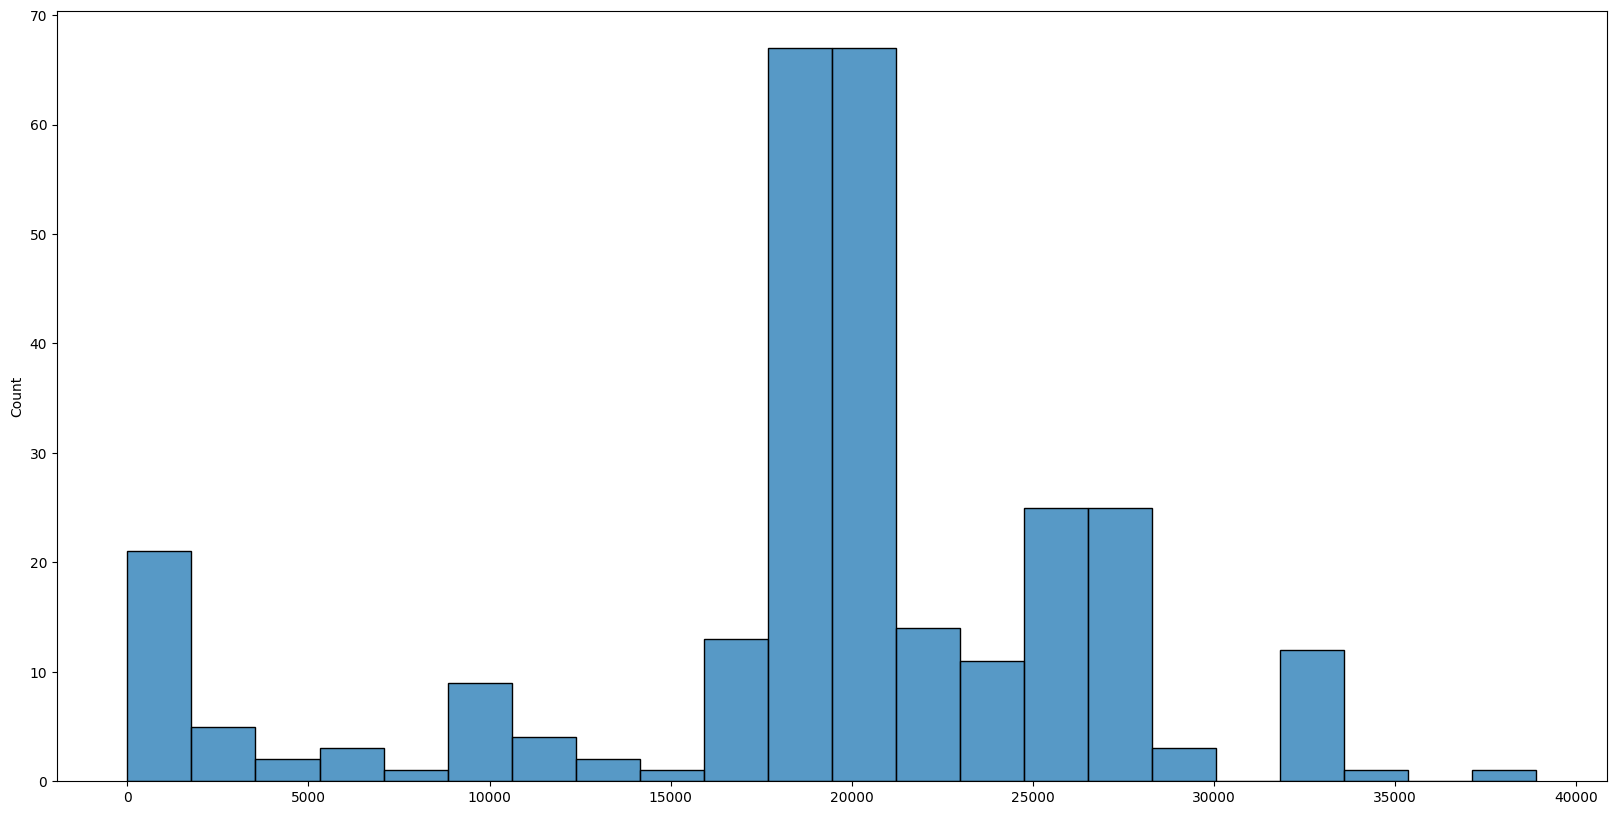

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x=prices, ax=ax)